## Phase 1: Data Preprocessing


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Data Loading
def load_data(file_path, encoding="utf-8"):
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        print("Dataset Loaded Successfully!")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Step 2: Data Exploration
def explore_data(df):
    print("\nDataset Overview:")
    print(df.head())  # First 5 rows
    print("\nData Types & Missing Values:")
    print(df.info())  # Data types and missing values
    print("\nStatistical Summary:")
    print(df.describe())  # Summary of numerical data
    print("\nMissing Values Count:")
    print(df.isnull().sum())  # Count of missing values per column

# Step 3: Data Cleaning
def clean_data(df):
    # Handling missing values (mean for numerical, mode for categorical)

    for col in df.columns:

        if df[col].dtype == "object":  # Categorical
            df[col] = df[col].fillna(df[col].mode()[0])
        else:  # Numerical
            df[col] = df[col].fillna(df[col].mean()) ## all the data is numerical 

    # Removing duplicates

    before = len(df)  # Number of rows before dropping duplicates
    df.drop_duplicates(inplace=True)
    after = len(df)  # Number of rows after dropping duplicates
    dropped = before - after  # Number of duplicates dropped
    print(f"Rows dropped: {dropped}")


    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    print("\nOutliers removed using IQR method!")
    return df

# Step 4: Data Transformation
def transform_data(df, scaler_type="standard"):
    # Drop ID columns
    df = df.drop(columns=["Id"], errors="ignore")

  
    num_cols = df.select_dtypes(include=[np.number]).columns.drop("Outcome", errors="ignore")
    scaler = StandardScaler() if scaler_type == "standard" else MinMaxScaler() # mean 0 SD as 1 in standard scaler
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # Reset index
    df.reset_index(drop=True, inplace=True)

    print("\nData Transformation Completed!")
    return df 



In [2]:

# Example Usage:
file_path = "data.csv"
df = load_data(file_path)

if df is not None:
    explore_data(df)
    df = clean_data(df)
    df = transform_data(df)
    print("\nFinal Processed Dataset:\n", df.head())

    # Save the preprocessed dataset
    df.to_csv("processed_dataset.csv", index=False)
    print("\nProcessed data saved successfully!")

Dataset Loaded Successfully!

Dataset Overview:
   Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   
3   4            1       89             66             23       94  28.1   
4   5            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Data Types & Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------

## Phase 2: Exploratory Data Analysis (EDA)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

# Set plotting style
sns.set(style="whitegrid")

# Load Preprocessed Data
def load_preprocessed_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 1️ **Univariate Analysis**
def univariate_analysis(df):
    print("\n🔹 Univariate Analysis Started...")

    # Histograms for continuous variables
    df.hist(figsize=(12, 8), bins=20, edgecolor="black")
    plt.suptitle("Feature Distributions", fontsize=14)
    plt.show()

    # Boxplots for outlier detection
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.title("Box Plot for Outlier Detection")
    plt.show()

    # Bar charts for categorical variables
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in categorical_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=df[col], palette="coolwarm")
        plt.title(f"Distribution of {col}")
        plt.show()

    print(" Univariate Analysis Completed!")

# 2️ **Bivariate & Multivariate Analysis**
def bivariate_multivariate_analysis(df):
    print("\n🔹 Bivariate & Multivariate Analysis Started...")

    # Correlation Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # Pair Plot for Variable Interactions
    sns.pairplot(df, hue="Outcome", diag_kind="kde", plot_kws={'alpha': 0.5})
    plt.show()

    # Scatter plots for numerical features vs Outcome
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        if col != "Outcome":
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df["Outcome"], alpha=0.6)
            plt.title(f"{col} vs Outcome")
            plt.show()

    print("Bivariate & Multivariate Analysis Completed!")

# 3️ **Feature Importance Analysis**
def feature_analysis(df):
    print("\n🔹 Feature Importance Analysis Started...")

    # Calculate correlation with Outcome
    corr_values = df.corr()["Outcome"].drop("Outcome").sort_values(ascending=False)
    print("\nFeature Correlations with Outcome:\n", corr_values)

    # Mutual Information Score for categorical & numerical features
    X = df.drop(columns=["Outcome"])
    y = df["Outcome"]
    
    # Compute Mutual Information Scores
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(10, 5))
    mi_scores.plot(kind="bar", color="teal")
    plt.title("Feature Importance (Mutual Information Score)")
    plt.ylabel("Score")
    plt.show()

    print("Feature Importance Analysis Completed!")

# **Run the EDA Pipeline**
def run_eda_pipeline(file_path):
    df = load_preprocessed_data(file_path)
    univariate_analysis(df)
    bivariate_multivariate_analysis(df)
    feature_analysis(df)




🔹 Univariate Analysis Started...


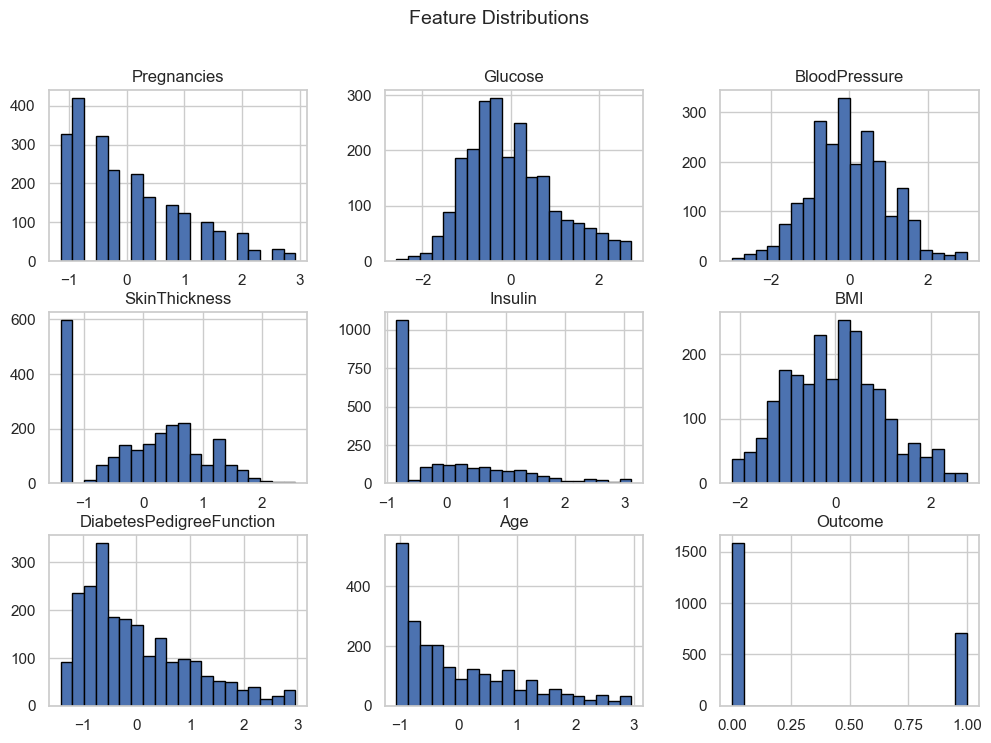

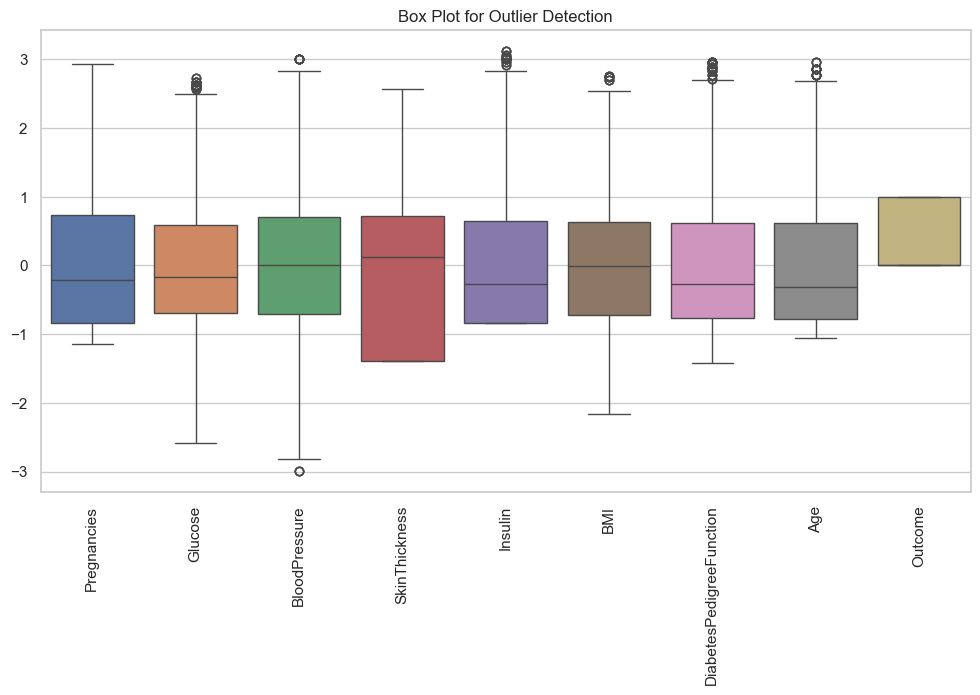

 Univariate Analysis Completed!

🔹 Bivariate & Multivariate Analysis Started...


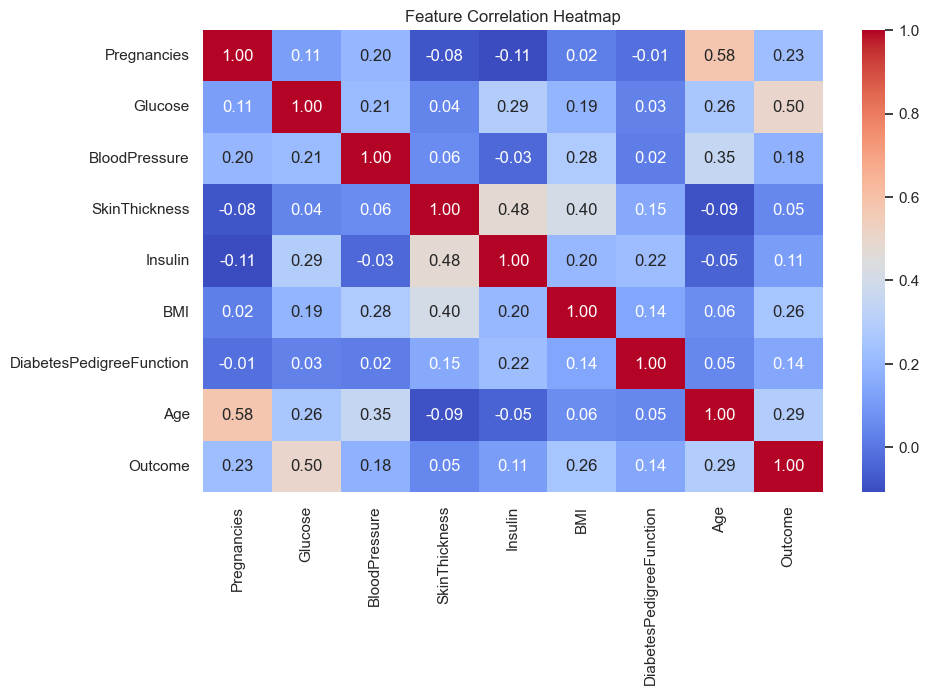

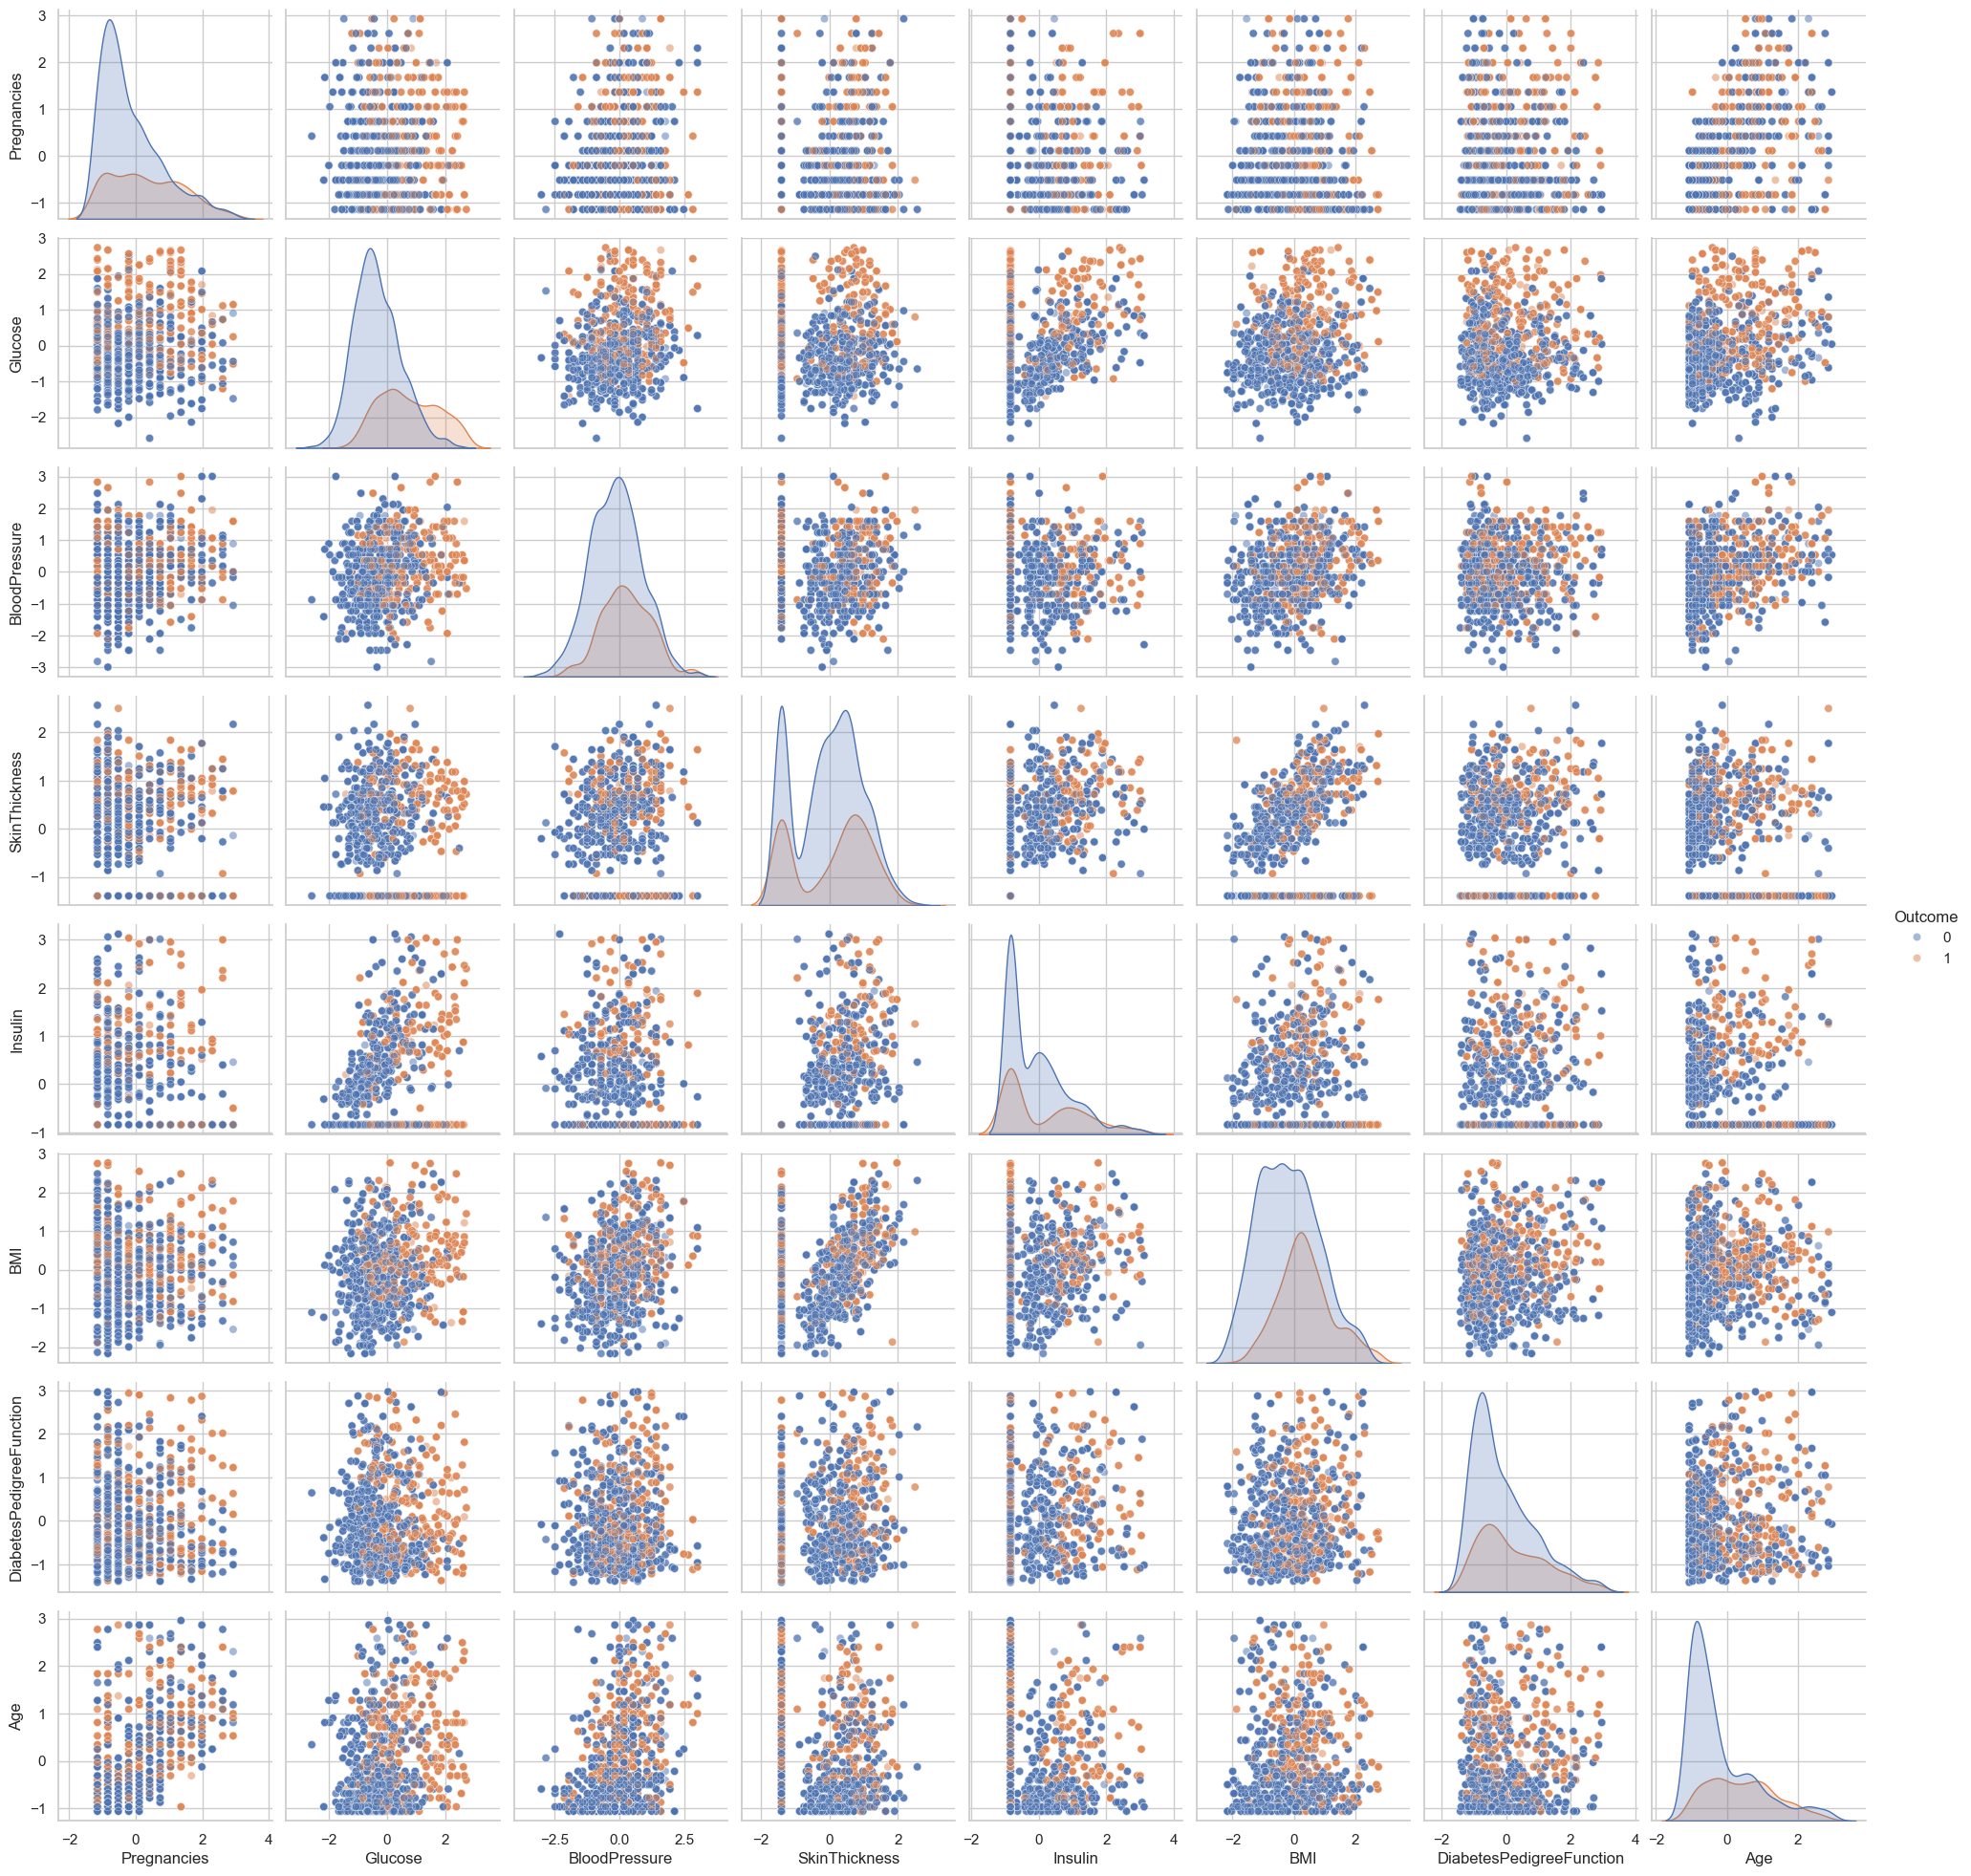

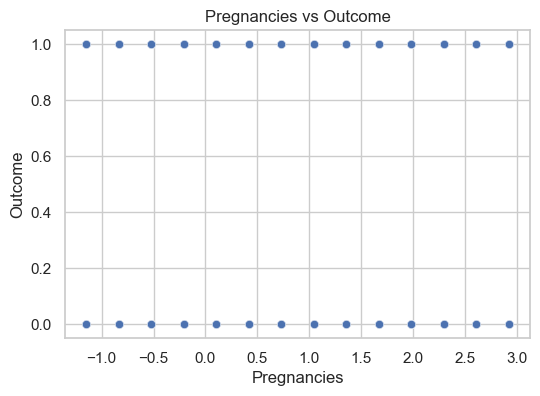

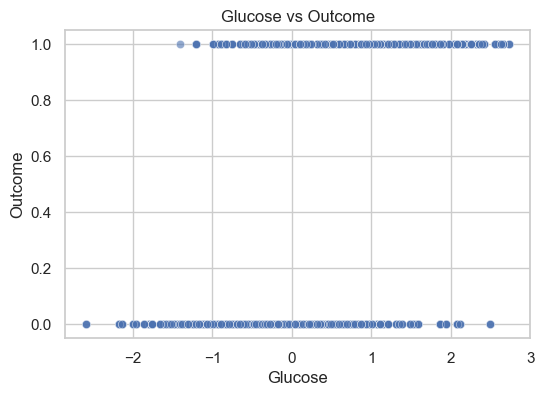

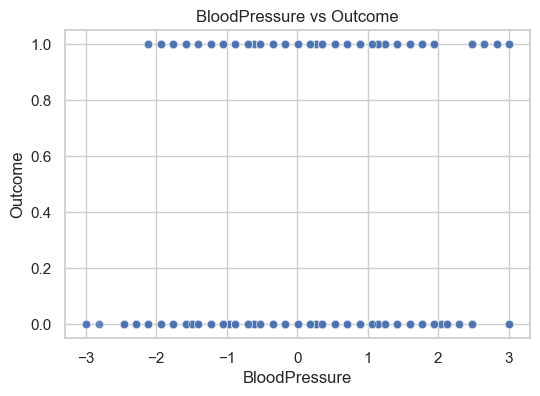

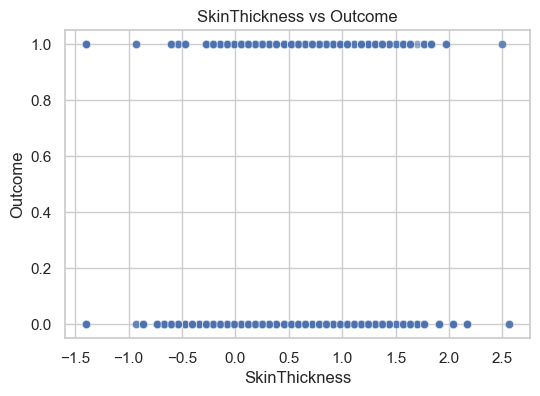

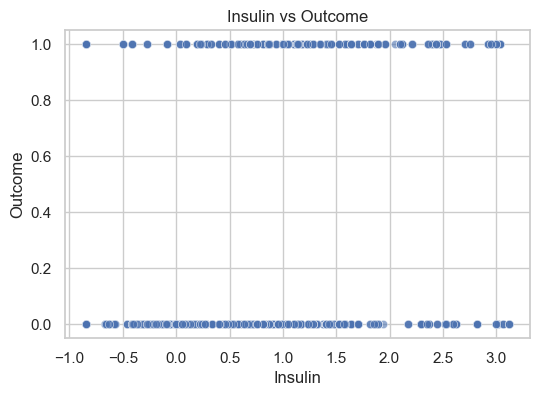

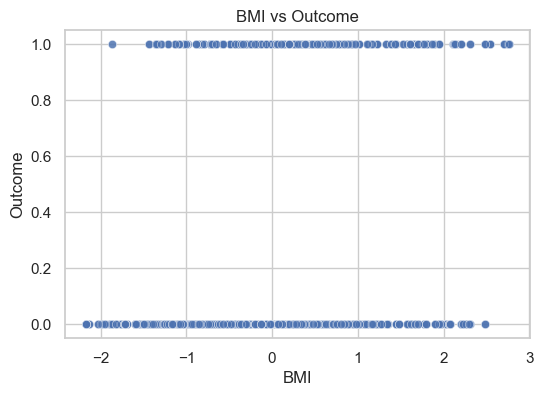

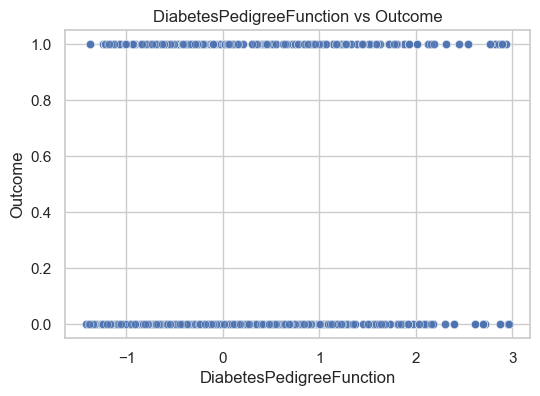

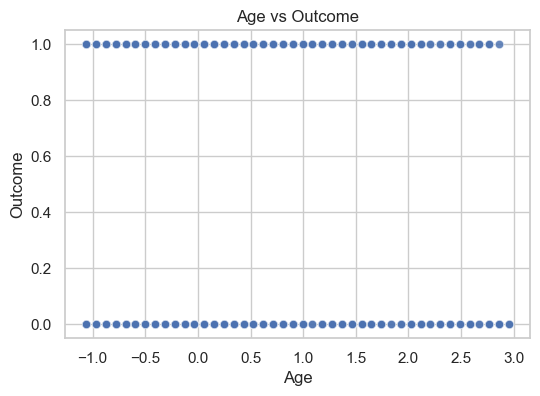

Bivariate & Multivariate Analysis Completed!

🔹 Feature Importance Analysis Started...

Feature Correlations with Outcome:
 Glucose                     0.498474
Age                         0.289319
BMI                         0.256032
Pregnancies                 0.225543
BloodPressure               0.177605
DiabetesPedigreeFunction    0.142697
Insulin                     0.113325
SkinThickness               0.046995
Name: Outcome, dtype: float64


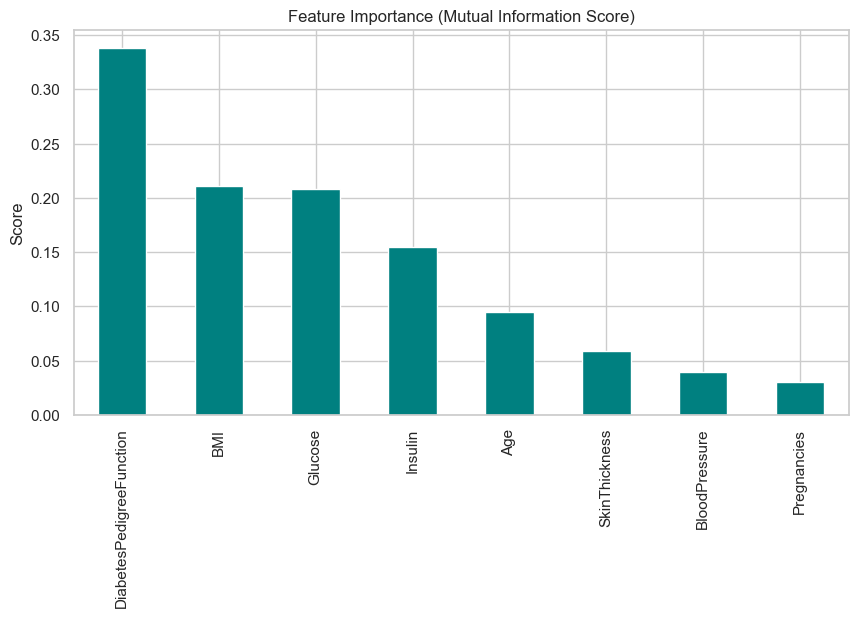

Feature Importance Analysis Completed!


In [13]:

run_eda_pipeline("processed_dataset.csv")

## Feature Selection:

🔍 Feature Selection Analysis
--------------------------------------------------

1. Statistical Filter Methods:

2. Random Forest Feature Importance:

3. Recursive Feature Elimination:

4. PCA-Based Feature Importance:

Top Features by Different Methods:
ANOVA F-Score: Glucose, Age, BMI, Pregnancies
Mutual Information: DiabetesPedigreeFunction, BMI, Glucose, Insulin
Random Forest: Glucose, Age, BMI, DiabetesPedigreeFunction
RFE: Glucose, BMI, DiabetesPedigreeFunction, Age
PCA: Insulin, SkinThickness, Glucose, BMI


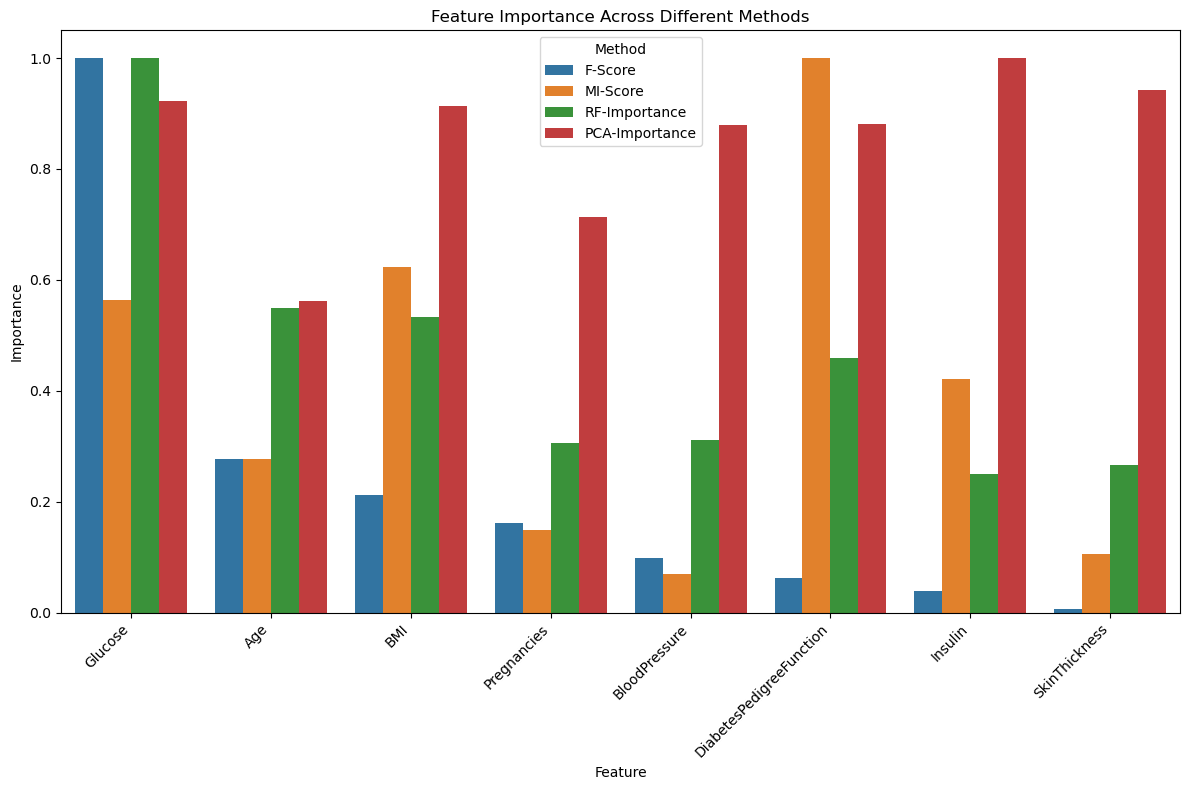


Consensus Top Features (Rank-Based Voting):
1. Glucose
2. BMI
3. DiabetesPedigreeFunction
4. Age
5. BloodPressure


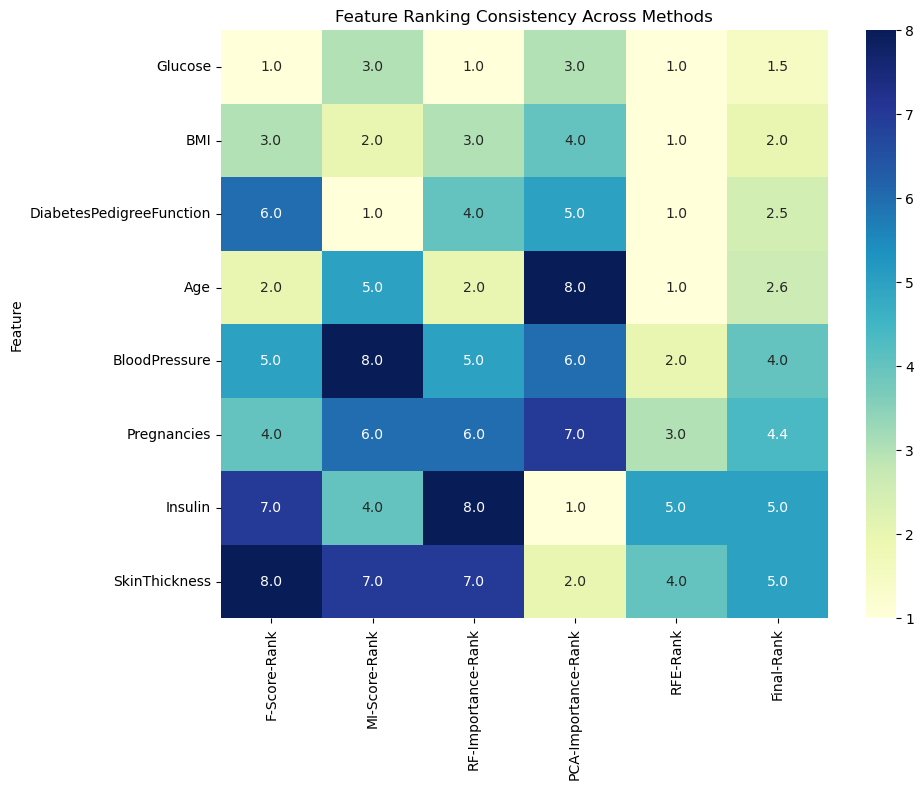


Recommended features for model training: Glucose, BMI, DiabetesPedigreeFunction, Age, BloodPressure


In [2]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import seaborn as sns

# Comprehensive Feature Selection Analysis
import matplotlib.pyplot as plt

print("🔍 Feature Selection Analysis")
print("-" * 50)

# Load the preprocessed data
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 1. Filter Methods
print("\n1. Statistical Filter Methods:")

# 1.1 ANOVA F-value
f_selector = SelectKBest(f_classif, k='all')
f_selector.fit(X, y)
f_scores = pd.DataFrame({'Feature': X.columns, 
                         'F-Score': f_selector.scores_,
                         'p-value': f_selector.pvalues_})
f_scores = f_scores.sort_values('F-Score', ascending=False)

# 1.2 Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k='all')
mi_selector.fit(X, y)
mi_scores = pd.DataFrame({'Feature': X.columns, 
                          'MI-Score': mi_selector.scores_})
mi_scores = mi_scores.sort_values('MI-Score', ascending=False)

# 2. Embedded Method - Random Forest Importance
print("\n2. Random Forest Feature Importance:")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.DataFrame({'Feature': X.columns, 
                              'RF-Importance': rf.feature_importances_})
rf_importance = rf_importance.sort_values('RF-Importance', ascending=False)

# 3. Recursive Feature Elimination
print("\n3. Recursive Feature Elimination:")
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=4)
rfe.fit(X, y)
rfe_scores = pd.DataFrame({'Feature': X.columns, 
                           'RFE-Rank': rfe.ranking_})
rfe_scores = rfe_scores.sort_values('RFE-Rank')

# 4. PCA-based importance (using component_df from earlier cell)
print("\n4. PCA-Based Feature Importance:")
# Using absolute values to measure overall importance across all components
pca_importance = pd.DataFrame({'Feature': component_df.columns,
                              'PCA-Importance': np.abs(component_df.values).mean(axis=0)})
pca_importance = pca_importance.sort_values('PCA-Importance', ascending=False)

# Combine all feature importance scores into one DataFrame
all_scores = f_scores[['Feature', 'F-Score']].merge(
    mi_scores[['Feature', 'MI-Score']], on='Feature').merge(
    rf_importance[['Feature', 'RF-Importance']], on='Feature').merge(
    rfe_scores[['Feature', 'RFE-Rank']], on='Feature').merge(
    pca_importance[['Feature', 'PCA-Importance']], on='Feature')

# Normalize scores for comparison (except RFE-Rank)
for col in ['F-Score', 'MI-Score', 'RF-Importance', 'PCA-Importance']:
    all_scores[f'{col}-Norm'] = all_scores[col] / all_scores[col].max()

# Print top features by each method
print("\nTop Features by Different Methods:")
print(f"ANOVA F-Score: {', '.join(f_scores['Feature'].head(4).tolist())}")
print(f"Mutual Information: {', '.join(mi_scores['Feature'].head(4).tolist())}")
print(f"Random Forest: {', '.join(rf_importance['Feature'].head(4).tolist())}")
print(f"RFE: {', '.join(rfe_scores[rfe_scores['RFE-Rank'] == 1]['Feature'].tolist())}")
print(f"PCA: {', '.join(pca_importance['Feature'].head(4).tolist())}")

# Visualize feature importance across methods
plt.figure(figsize=(12, 8))
importance_norm = all_scores[['Feature', 'F-Score-Norm', 'MI-Score-Norm', 
                              'RF-Importance-Norm', 'PCA-Importance-Norm']]
importance_melted = pd.melt(importance_norm, id_vars=['Feature'], 
                            var_name='Method', value_name='Importance')
importance_melted['Method'] = importance_melted['Method'].str.replace('-Norm', '')

sns.barplot(x='Feature', y='Importance', hue='Method', data=importance_melted)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Across Different Methods')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# Create a rank-based voting system for feature selection
# First convert all metrics to ranks
rank_cols = []
for col in ['F-Score', 'MI-Score', 'RF-Importance', 'PCA-Importance']:
    rank_col = f'{col}-Rank'
    all_scores[rank_col] = all_scores[col].rank(ascending=False)
    rank_cols.append(rank_col)

# Calculate the average rank
all_scores['Avg-Rank'] = all_scores[rank_cols].mean(axis=1)
# Also add RFE-Rank to the average
all_scores['Final-Rank'] = (all_scores['Avg-Rank'] + all_scores['RFE-Rank']) / 2
all_scores = all_scores.sort_values('Final-Rank')

# Select top N features (e.g., top 5)
top_features = all_scores.head(5)['Feature'].tolist()

print("\nConsensus Top Features (Rank-Based Voting):")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

# Display consistency heatmap of rankings
plt.figure(figsize=(10, 8))
rank_df = all_scores[['Feature'] + rank_cols + ['RFE-Rank', 'Final-Rank']]
rank_df = rank_df.set_index('Feature')
sns.heatmap(rank_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Feature Ranking Consistency Across Methods')
plt.tight_layout()
plt.show()

print(f"\nRecommended features for model training: {', '.join(top_features)}")

## random forest 100% accuracy

Accuracy: 100.00%
Confusion Matrix:
 [[320   0]
 [  0 139]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       139

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459



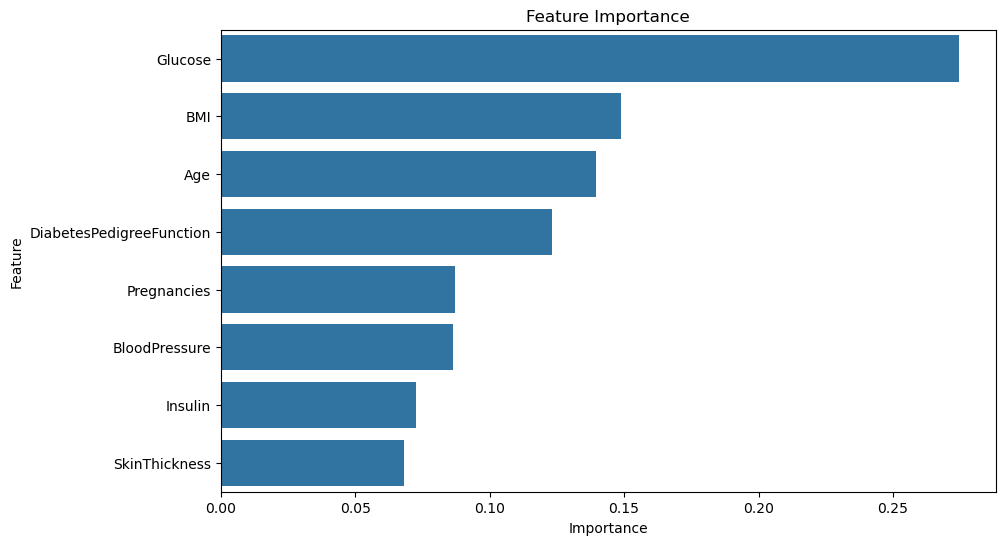

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Load Data
df = pd.read_csv('processed_dataset.csv')  # Replace with your dataset path

# Splitting Data into Features and Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Feature Importance Visualization
coefficients = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
coefficients.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()



In [ ]:
import joblib

# Save the model to a file
joblib.dump(model, 'models/random_forest_model.pkl')
print("Model saved successfully!")



Model saved successfully!


In [ ]:
# To load the model later, you can use:
loaded_model = joblib.load('models/random_forest_model.pkl')

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


## logistic regression

Accuracy: 80.39%
Confusion Matrix:
 [[290  30]
 [ 60  79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       320
           1       0.72      0.57      0.64       139

    accuracy                           0.80       459
   macro avg       0.78      0.74      0.75       459
weighted avg       0.80      0.80      0.80       459



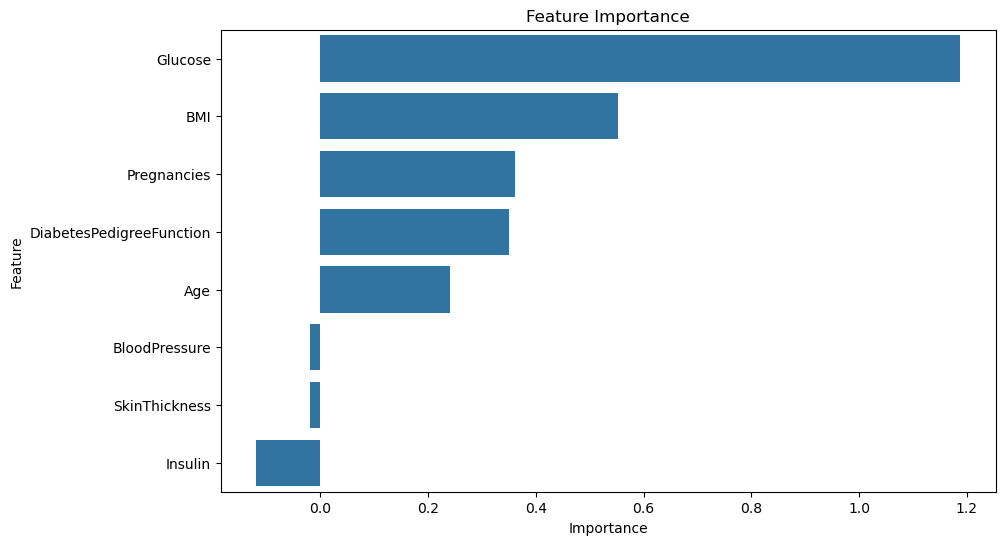

In [1]:

# Splitting Data into Features and Target
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Data
df = pd.read_csv('processed_dataset.csv')  # Replace with your dataset path

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Feature Importance Visualization
coefficients = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
coefficients.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()


In [ ]:
import joblib

# Save the logistic regression model to a file
joblib.dump(model, 'models/logistic_regression_model.pkl')
print("Logistic Regression model saved successfully!")



Logistic Regression model saved successfully!


In [ ]:
# Load the model and run inference on test dataset
loaded_model = joblib.load('models/logistic_regression_model.pkl')

# Make predictions with loaded model
loaded_pred = loaded_model.predict(X_test)

# Verify the predictions match the original ones
match_percentage = (loaded_pred == y_pred).mean() * 100
print(f"Predictions from loaded model match original: {match_percentage:.2f}%")

# Check accuracy of loaded model
loaded_accuracy = accuracy_score(y_test, loaded_pred)
print(f"Loaded model accuracy: {loaded_accuracy * 100:.2f}%")


Predictions from loaded model match original: 100.00%
Loaded model accuracy: 80.39%


## Neural Network

C:\Users\mdali\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5208 - loss: 0.7114 - val_accuracy: 0.7139 - val_loss: 0.5717
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6930 - loss: 0.5829 - val_accuracy: 0.7439 - val_loss: 0.5177
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7395 - loss: 0.5152 - val_accuracy: 0.7575 - val_loss: 0.4852
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7616 - loss: 0.4831 - val_accuracy: 0.7738 - val_loss: 0.4697
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7874 - loss: 0.4517 - val_accuracy: 0.7629 - val_loss: 0.4611
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7775 - loss: 0.4472 - val_accuracy: 0.7766 - val_loss: 0.4509
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7847 - loss: 0.4501 - val_accuracy: 0.7711 - val_loss: 0.4487
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7626 - loss: 0.4538 - val_accuracy: 0.

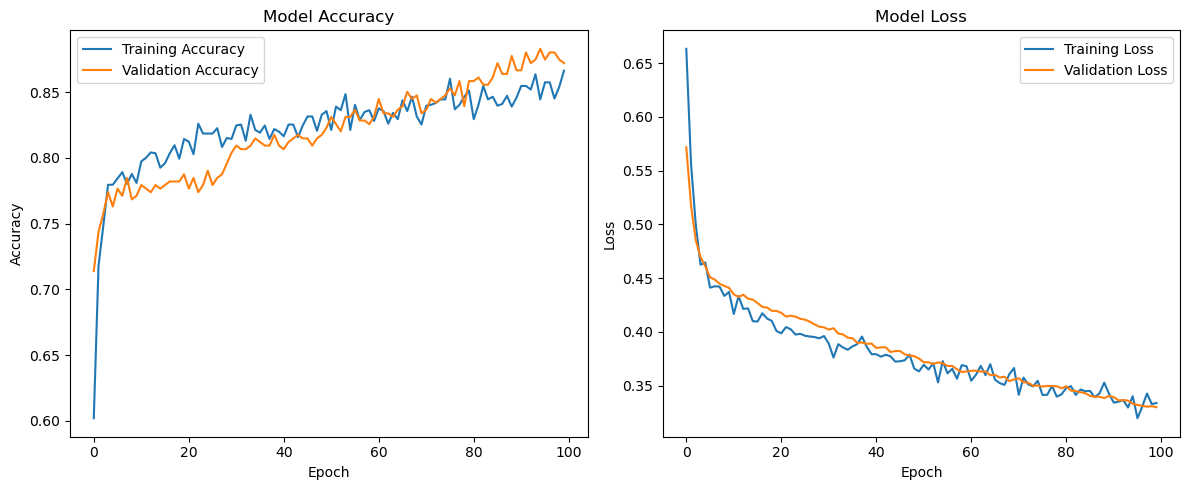

Neural Network model saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
df = pd.read_csv('processed_dataset.csv')

# Splitting Data into Features and Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Get the number of input features
input_dim = X_train.shape[1]

# Build the Neural Network Model
model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save('neural_network_model.h5')
print("Neural Network model saved successfully!")

In [ ]:
model.save('models/neural_network_model.keras')

In [4]:
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Data
df = pd.read_csv('processed_dataset.csv')

# Splitting Data into Features and Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Load the saved neural network model and evaluate it on the test dataset

# Load the saved model
loaded_nn_model = load_model('models/neural_network_model.keras')

# Evaluate the model on test data
y_pred_prob = loaded_nn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
nn_accuracy = accuracy_score(y_test, y_pred)
print(f"Neural Network model accuracy: {nn_accuracy * 100:.2f}%")

# Display confusion matrix
nn_conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(nn_conf_matrix)

# Generate classification report
nn_class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(nn_class_report)

C:\Users\mdali\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Neural Network model accuracy: 84.31%

Confusion Matrix:
[[283  37]
 [ 35 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       320
           1       0.74      0.75      0.74       139

    accuracy                           0.84       459
   macro avg       0.81      0.82      0.82       459
weighted avg       0.84      0.84      0.84       459

